In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams["font.family"] = "Calibri"


def find_outliers(df, threshold=2):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Skip the "t1" and "t2" columns
        if col == "t1" or col == "t2":
            continue

        # Calculate the mean and standard deviation of the column
        mean = df[col].mean()
        std = df[col].std()

        # Find outliers in this column
        outliers = (df[col] - mean).abs() > threshold * std

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers)

    # Return the indices of the outliers
    outlier_indices = df[outlier_rows_mask].index
    return outlier_indices

In [4]:
df = pd.read_csv("../outputs/data_clean_glass_lai.csv")
df.set_index(pd.to_datetime(df.iloc[:, 0], format="%Y-%m-%d"), inplace=True)
df = df.drop(df.columns[0], axis=1)
df

,gpp,par,red,nir,fpar,lai,ndvi,nirv,nirvp,fesc,fesc_p,fesc_n,lue,name,type,glass_lai
Unnamed: 0,,,,,,,,,,,,,,,,
2002-07-16,3.031285,420.832083,0.0404,0.2484,0.7900,3.100000,0.720222,0.178903,75.288142,0.226460,95.301446,0.000538,0.009118,FR-LBr,ENF,2.9500
2002-07-17,2.519090,577.048542,0.0404,0.2484,0.7825,3.050000,0.720222,0.178903,103.235742,0.228630,131.930661,0.000396,0.005579,FR-LBr,ENF,2.9375
2002-07-18,2.383495,610.685319,0.0404,0.2484,0.7750,3.000000,0.720222,0.178903,109.253464,0.230843,140.972212,0.000378,0.005036,FR-LBr,ENF,2.9250
2002-07-19,1.905765,626.108542,0.0404,0.2484,0.7675,2.950000,0.720222,0.178903,112.012726,0.233098,145.944920,0.000372,0.003966,FR-LBr,ENF,2.9125
2002-07-20,2.383285,582.886875,0.0402,0.2481,0.7600,2.900000,0.721124,0.178911,104.284770,0.235409,137.216803,0.000404,0.005380,FR-LBr,ENF,2.9000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-09-23,2.144585,400.931125,0.0618,0.1934,0.3800,0.675000,0.515674,0.099731,39.985402,0.262451,105.224741,0.000655,0.014076,IT-PT1,DBF,1.1750
2004-09-24,1.838030,298.287125,0.0618,0.1935,0.3850,0.687500,0.515864,0.099820,29.774909,0.259272,77.337425,0.000869,0.016005,IT-PT1,DBF,1.1625
2004-09-25,1.706025,390.254542,0.0619,0.1936,0.3900,0.700000,0.515460,0.099793,38.944684,0.255880,99.858165,0.000656,0.011209,IT-PT1,DBF,1.1500


In [5]:
names = df["name"].unique()
types = df["type"].unique()

site_annual_max_lue = []
site_annual_max_lue_se = []
site_top_n = []
site_max_lue = []

for name in names:
    site_df = df[df["name"] == name]
    type = site_df["type"].iloc[0]
    site_df = site_df[["fpar", "nirv", "nirvp", "fesc", "lue", "lai", "glass_lai"]]

    # Calculate the annual maximum LUE
    annual_max_lue_index = site_df.groupby(site_df.index.year)["lue"].idxmax()
    # if len(annual_max_lue_index) <3:
    #     print(name)
    #     continue
    annual_max = site_df.loc[annual_max_lue_index]
    annual_max_mean = annual_max.max()
    annual_max_mean.loc["type"] = type
    annual_max_mean.loc["name"] = name

    annual_max_std = annual_max.std()
    n = len(annual_max)
    annual_max_se = annual_max_std / np.sqrt(n)
    annual_max_se.loc["type"] = type
    annual_max_se.loc["name"] = name

    site_annual_max_lue.append(annual_max_mean)
    site_annual_max_lue_se.append(annual_max_se)

site_annual_max_lue = pd.DataFrame(site_annual_max_lue)
site_annual_max_lue_se = pd.DataFrame(site_annual_max_lue_se)
len(site_annual_max_lue)

326

In [6]:
site_annual_max_lue = pd.merge(
    site_annual_max_lue, merged_coords[["name", "Lat", "Lon"]], on="name", how="left"
)
site_annual_max_lue

,fpar,nirv,nirvp,fesc,lue,lai,glass_lai,type,name,Lat,Lon
0,0.7700,0.238011,36.087274,0.344943,0.080114,2.30,2.800,ENF,FR-LBr,44.7171,-0.7693
1,0.2400,0.072176,22.214145,0.375259,0.055554,0.50,0.600,OSH,US-Rws,43.1675,-116.7132
2,0.6700,0.139501,25.641101,0.394350,0.059184,1.40,1.400,ENF,US-NC3,35.7990,-76.6560
3,0.4600,0.138897,20.209083,0.301950,0.018404,0.90,0.800,GRA,CN-Du3,42.0551,116.2809
4,0.9050,0.351047,137.584321,0.556535,0.033362,5.70,5.000,WET,US-Los,46.0827,-89.9792
...,...,...,...,...,...,...,...,...,...,...,...
321,0.5275,0.093241,41.307434,0.177661,0.024023,1.25,1.500,ENF,US-Me3,44.3154,-121.6078
322,0.5100,0.159522,73.047614,0.316932,0.035076,1.60,1.600,SAV,AU-DaS,-14.1593,131.3881
323,0.4400,0.171822,104.510323,0.402319,0.034163,1.05,1.825,GRA,US-Sne,38.0369,-121.7547
324,0.3250,0.090013,28.715518,0.314493,0.030957,0.90,1.600,OSH,ES-LgS,37.0979,-2.9658


In [7]:
# def rename_based_on_lat(row):
#     # if row['type'] in ['ENF', 'DBF']:
#     lat = abs(row["Lat"])
#     if lat < 25:
#         suffix = "low"
#     elif lat < 55:
#         suffix = "mid"
#     else:
#         suffix = "high"

#     row["type"] = row["type"] + "_" + suffix
#     row["name"] = row["name"] + "_" + suffix
#     return row


# site_annual_max_lue = site_annual_max_lue.apply(rename_based_on_lat, axis=1)
# site_annual_max_lue

In [8]:
# names = site_annual_max_lue["name"].unique()
# types = site_annual_max_lue["type"].unique()

In [9]:
# Select the columns to find outliers in
columns_to_check = ["lue", "fesc", "fpar", "nirv", "nirvp", "lai", "glass_lai"]
# columns_to_check = ["lue", "fesc", "fesc_p","fesc_n"]


# Create a copy of the DataFrame with only the columns to check
df_to_check = site_annual_max_lue[columns_to_check].copy()

# Use the find_outliers function to find the indices of the outliers
outlier_indices = find_outliers(df_to_check, threshold=3)

# Drop the rows with outliers from the original DataFrame
site_annual_max_lue_clean = site_annual_max_lue.drop(outlier_indices)
site_annual_max_lue = site_annual_max_lue_clean
site_annual_max_lue = site_annual_max_lue.groupby("type").filter(lambda x: len(x) >= 3)
len(site_annual_max_lue)

314

In [10]:
site_annual_max_lue.to_csv("../outputs/site_annual_max_lue.csv", index=False)

In [11]:
df.groupby("type").size().sum()

289349

In [12]:
types = site_annual_max_lue["type"].unique()
names = site_annual_max_lue["name"].unique()
types

array(['ENF', 'OSH', 'GRA', 'WET', 'MF', 'DBF', 'SAV', 'EBF', 'WSA',
       'CRO', 'CSH'], dtype=object)

/tmp/ipykernel_10777/1319377270.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


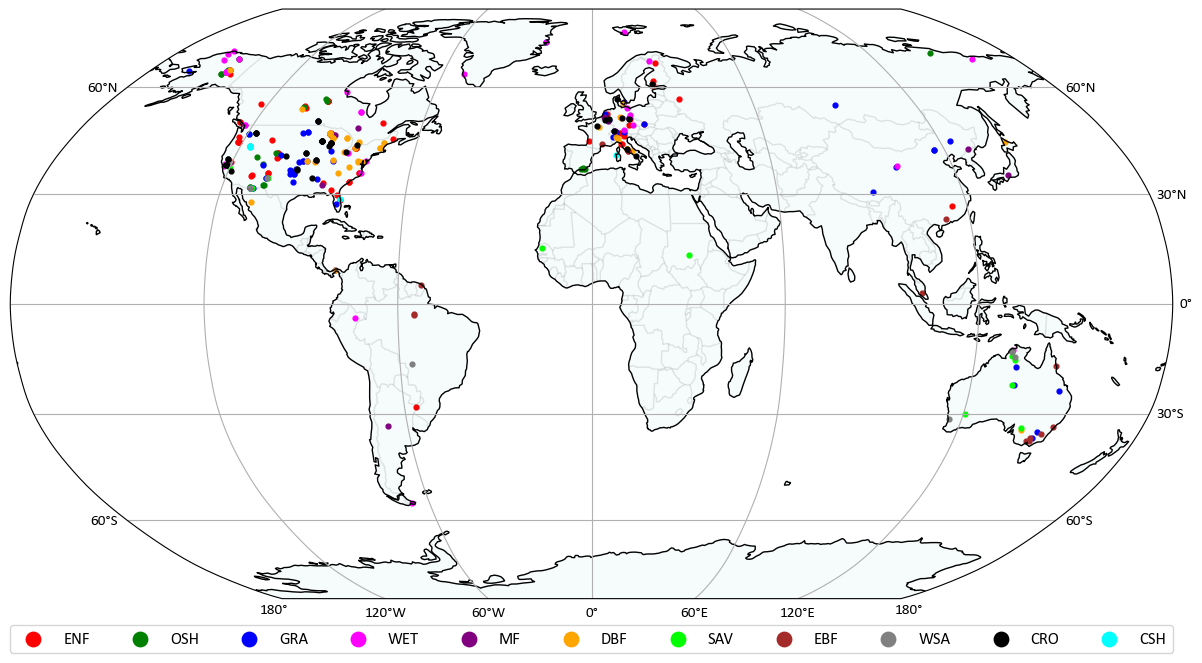

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the world boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Create a GeoDataFrame from your data
gdf = gpd.GeoDataFrame(
    site_annual_max_lue,
    geometry=gpd.points_from_xy(site_annual_max_lue.Lon, site_annual_max_lue.Lat),
)

# Define a dictionary of colors for each site type
colors = [
    "red",
    "green",
    "blue",
    "magenta",
    "purple",
    "orange",
    "lime",
    "brown",
    "gray",
    "black",
    "cyan",
]
type_color_dict = dict(zip(types, colors))

# Create a larger figure and plot the world
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(
    cfeature.LAND, color="lightblue", alpha=0.1
)  # add a faint blue color to the land
ax.coastlines()
ax.add_feature(cfeature.BORDERS, alpha=0.1)
gridlines = ax.gridlines(draw_labels=True)
gridlines.top_labels = False
gridlines.left_labels = False

gridlines.xlabel_style = {"size": 11, "color": "black"}
gridlines.ylabel_style = {"size": 11, "color": "black"}

# Plot the sites with different colors based on the type
for site_type in types:
    site_data = gdf[gdf["type"] == site_type]
    scatter = ax.scatter(
        site_data["Lon"],
        site_data["Lat"],
        color=type_color_dict[site_type],
        s=12,
        transform=ccrs.PlateCarree(),
        label=site_type,
    )

# Add a legend at the bottom
ax.legend(
    bbox_to_anchor=(0.5, -0.03), loc="upper center", ncol=11, fontsize=12, markerscale=3
)

plt.savefig("../outputs/figures/annual_max_lue_map.png", dpi=300, bbox_inches="tight")

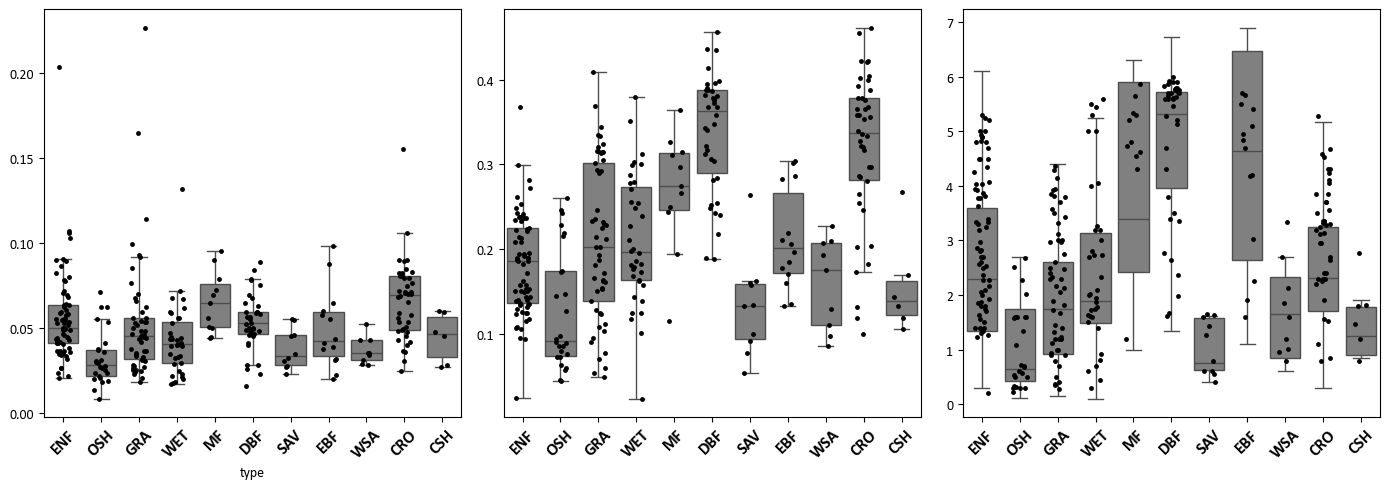

In [14]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))

# Plot the boxplot of "lue" on the first subplot
sns.boxplot(
    x="type", y="lue", data=site_annual_max_lue, showfliers=False, ax=ax1, color="gray"
)
sns.stripplot(
    x="type",
    y="lue",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax1,
)
# ax1.set_ylabel(r"$\bar{LUE_{Max}}$", fontsize=14, weight="bold")
ax1.set_ylabel("")
# ax1.set_xlabel("")

# Plot the boxplot of "fesc" on the second subplot
sns.boxplot(
    x="type", y="nirv", data=site_annual_max_lue, showfliers=False, ax=ax2, color="gray"
)
sns.stripplot(
    x="type",
    y="nirv",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax2,
)
ax2.set_ylabel("", fontsize=14, weight="bold")
ax2.set_xlabel("")

# Plot the boxplot of "fesc" on the second subplot
sns.boxplot(
    x="type",
    y="lai",
    data=site_annual_max_lue,
    showfliers=False,
    ax=ax3,
    color="gray",
)
sns.stripplot(
    x="type",
    y="glass_lai",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax3,
)
ax3.set_ylabel("", fontsize=16, weight="bold")
ax3.set_xlabel("")

for label in ax1.get_xticklabels():
    label.set_weight("bold")
for label in ax2.get_xticklabels():
    label.set_weight("bold")
for label in ax3.get_xticklabels():
    label.set_weight("bold")

ax1.tick_params(axis="x", rotation=45, labelsize=12)
ax2.tick_params(axis="x", rotation=45, labelsize=12)
ax3.tick_params(axis="x", rotation=45, labelsize=12)
plt.tight_layout()
plt.savefig(
    "../outputs/figures/annual_max_lue_boxplot.png", dpi=300, bbox_inches="tight"
)

In [15]:
site_annual_max_lue = site_annual_max_lue[site_annual_max_lue["fesc"] <= 1]
site_annual_max_lue_se = site_annual_max_lue_se[
    site_annual_max_lue_se.index.isin(site_annual_max_lue.index)
]
site_annual_max_lue_grouped_mean = (
    site_annual_max_lue[
        ["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai", "glass_lai"]
    ]
    .groupby("type")
    .median()
)
site_annual_max_lue_grouped_std = (
    site_annual_max_lue[
        ["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai", "glass_lai"]
    ]
    .groupby("type")
    .std()
)
n = site_annual_max_lue.groupby("type").size()
site_annual_max_lue_grouped_se = site_annual_max_lue_grouped_std.div(np.sqrt(n), axis=0)

In [16]:
site_annual_max_lue_grouped_mean.to_csv("../outputs/annual_max_lue_map.csv")

In [17]:
site_annual_max_lue_grouped_std.to_csv("../outputs/annual_max_lue_map_std.csv")

In [18]:
types = site_annual_max_lue_grouped_mean.index
nirv = site_annual_max_lue_grouped_mean["nirv"].values
lue = site_annual_max_lue_grouped_mean["lue"].values
nirv_std = site_annual_max_lue_grouped_std["nirv"].values
lue_std = site_annual_max_lue_grouped_std["lue"].values
lai = site_annual_max_lue_grouped_mean["lai"].values
lai_std = site_annual_max_lue_grouped_std["lai"].values

y = 0.102073 x + 0.025343
R-squared: 0.642780
Overall p-value: 0.002999
Individual p-values: NIRv: 0.007540, Intercept: 0.004211


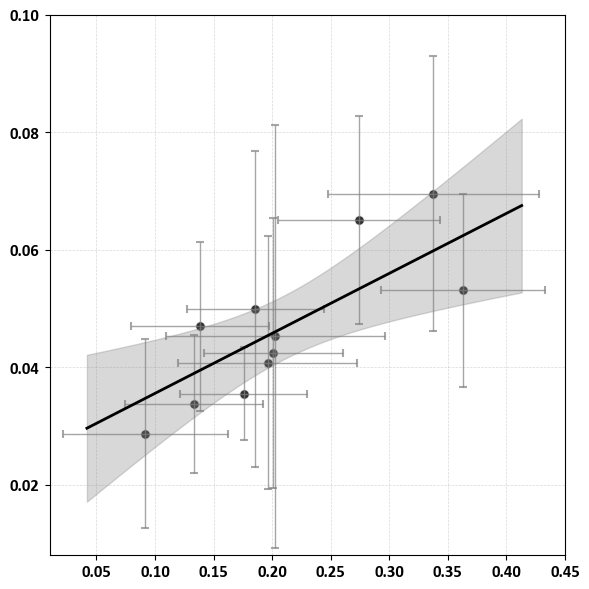

In [19]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming 'types', 'nirv_std', 'lue_std', 'nirv', and 'lue' are defined earlier in your code

# Count measurements for each type
num_measurements = site_annual_max_lue["type"].value_counts()
num_measurements = num_measurements.reindex(types, fill_value=0).values

# Calculate weights as the inverse of the variance and number of measurements
weights = num_measurements / (nirv_std**2 + lue_std**2)

# Perform weighted linear regression
A = np.vstack([nirv, np.ones_like(nirv)]).T
weighted_A = A * np.sqrt(weights[:, np.newaxis])
weighted_lue = lue * np.sqrt(weights)

# Solve weighted least squares
beta_linear, _, _, _ = np.linalg.lstsq(weighted_A, weighted_lue, rcond=None)

# Calculate the predicted values
y_pred = beta_linear[0] * nirv + beta_linear[1]

# Calculate the residuals
residuals = lue - y_pred

# Calculate the total sum of squares
SST = np.sum((lue - np.mean(lue)) ** 2)

# Calculate the residual sum of squares
SSR = np.sum(residuals**2)

# Calculate the regression sum of squares
SSM = SST - SSR

# Calculate degrees of freedom
df_total = len(lue) - 1
df_residual = len(lue) - 2
df_model = 1

# Calculate mean squares
MSM = SSM / df_model
MSR = SSR / df_residual

# Calculate F-statistic
F = MSM / MSR

# Calculate overall p-value
p_value = 1 - stats.f.cdf(F, df_model, df_residual)

# Calculate individual p-values
n = len(nirv)
MSE = SSR / df_residual
se = np.sqrt(MSE * np.diag(np.linalg.inv(np.dot(A.T, A))))
t_stats = beta_linear / se
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df_residual))

plt.figure(figsize=(6, 6))

# Extract standard errors for lue and nirv
lue_se = site_annual_max_lue_grouped_std["lue"]
nirv_se = site_annual_max_lue_grouped_std["nirv"]

# Create error bars
(_, caps, _) = plt.errorbar(
    x=site_annual_max_lue_grouped_mean["nirv"],
    y=site_annual_max_lue_grouped_mean["lue"],
    xerr=nirv_se,
    yerr=lue_se,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
for cap in caps:
    cap.set_markeredgewidth(1.5)

# Add black bullets
plt.scatter(
    site_annual_max_lue_grouped_mean["nirv"],
    site_annual_max_lue_grouped_mean["lue"],
    color="black",
    alpha=0.8,
    edgecolor="white",
    s=50,
)

# Generate fitted values
x_min = site_annual_max_lue_grouped_mean["nirv"].min() - 0.05
x_max = site_annual_max_lue_grouped_mean["nirv"].max() + 0.05
x_fit = np.linspace(x_min, x_max, 100)
y_fit = beta_linear[0] * x_fit + beta_linear[1]

# Plot linear regression line
plt.plot(x_fit, y_fit, color="black", linewidth=2)

# Calculate confidence intervals
n = len(site_annual_max_lue_grouped_mean["nirv"])
mean_x = np.mean(site_annual_max_lue_grouped_mean["nirv"])
SS_x = np.sum((site_annual_max_lue_grouped_mean["nirv"] - mean_x) ** 2)
SE_y = np.sqrt(
    np.sum(
        (
            site_annual_max_lue_grouped_mean["lue"]
            - (
                beta_linear[0] * site_annual_max_lue_grouped_mean["nirv"]
                + beta_linear[1]
            )
        )
        ** 2
    )
    / (n - 2)
)
df = n - 2
t_score = stats.t.ppf((1 + 0.95) / 2, df)

conf_interval = t_score * SE_y * np.sqrt(1 / n + (x_fit - mean_x) ** 2 / SS_x)
y_fit_upper = y_fit + conf_interval
y_fit_lower = y_fit - conf_interval

# Add the confidence interval as a shaded area
plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color="gray", alpha=0.3)

# Get the current axes
ax = plt.gca()

# Add gridlines for better readability
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

plt.xticks(fontsize=12, weight="bold")
plt.yticks(fontsize=12, weight="bold")
plt.xlim(0.01, 0.45)
plt.ylim(0.008, 0.1)

plt.tight_layout()

# Print the equation, R-squared value, and p-values
print(f"y = {beta_linear[0]:.6f} x + {beta_linear[1]:.6f}")
print(
    f"R-squared: {r2_score(site_annual_max_lue_grouped_mean['lue'], beta_linear[0] * site_annual_max_lue_grouped_mean['nirv'] + beta_linear[1]):.6f}"
)
print(f"Overall p-value: {p_value:.6f}")
print(f"Individual p-values: NIRv: {p_values[0]:.6f}, Intercept: {p_values[1]:.6f}")

plt.savefig("../outputs/figures/lue_nirv_regression.png", dpi=300, bbox_inches="tight")
plt.show()

Linear fit: LUE_Max = 0.0064 * LAI + 0.0320
Linear R-squared: 0.1346
Linear p-values: LAI: 0.0354, Intercept: 0.0015
Linear overall p-value: 0.2671
Quadratic fit: LUE_Max = -0.0034 * LAI^2 + 0.0250 * LAI + 0.0142
Quadratic R-squared: 0.5152
Quadratic p-values: LAI^2: 0.0589, LAI: 0.0276, Intercept: 0.2427
Quadratic overall p-value: 0.0552


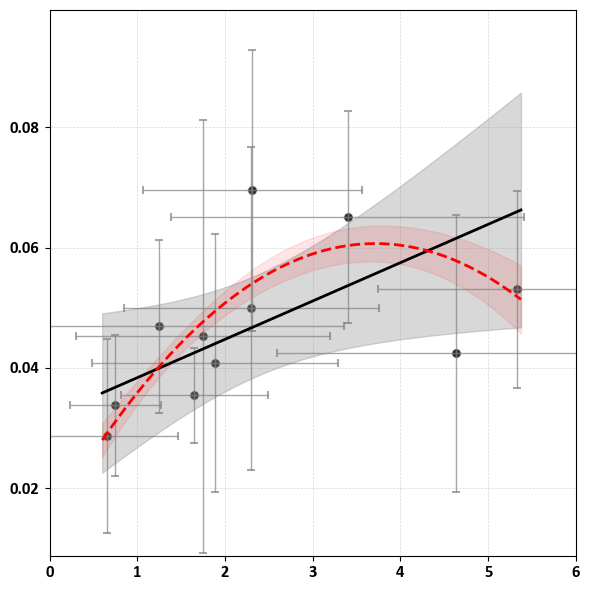

In [20]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming 'types', 'lai_std', 'lue_std', 'lai', and 'lue' are defined earlier in your code

# Count measurements for each type
num_measurements = site_annual_max_lue["type"].value_counts()
num_measurements = num_measurements.reindex(types, fill_value=0).values

# Calculate weights as the inverse of the variance and number of measurements
weights = num_measurements / (lai_std**2 + lue_std**2)

# Perform weighted linear regression
A = np.vstack([lai, np.ones_like(lai)]).T
weighted_A = A * np.sqrt(weights[:, np.newaxis])
weighted_lue = lue * np.sqrt(weights)

# Solve weighted least squares
beta_linear, _, _, _ = np.linalg.lstsq(weighted_A, weighted_lue, rcond=None)

# Perform weighted quadratic regression
A_quad = np.vstack([lai**2, lai, np.ones_like(lai)]).T
weighted_A_quad = A_quad * np.sqrt(weights[:, np.newaxis])
beta_quadratic, _, _, _ = np.linalg.lstsq(weighted_A_quad, weighted_lue, rcond=None)

# Calculate p-values for linear fit
n = len(lai)
y_pred_linear = beta_linear[0] * lai + beta_linear[1]
residuals_linear = lue - y_pred_linear
sse_linear = np.sum(residuals_linear**2)
mse_linear = sse_linear / (n - 2)
se_linear = np.sqrt(mse_linear * np.diag(np.linalg.inv(np.dot(A.T, A))))
t_stats_linear = beta_linear / se_linear
p_values_linear = 2 * (1 - stats.t.cdf(np.abs(t_stats_linear), n - 2))

# Calculate p-values for quadratic fit
y_pred_quad = beta_quadratic[0] * lai**2 + beta_quadratic[1] * lai + beta_quadratic[2]
residuals_quad = lue - y_pred_quad
sse_quad = np.sum(residuals_quad**2)
mse_quad = sse_quad / (n - 3)
se_quad = np.sqrt(mse_quad * np.diag(np.linalg.inv(np.dot(A_quad.T, A_quad))))
t_stats_quad = beta_quadratic / se_quad
p_values_quad = 2 * (1 - stats.t.cdf(np.abs(t_stats_quad), n - 3))

# Plotting
plt.figure(figsize=(6, 6))

# Extract standard errors for lue and lai
lue_se = site_annual_max_lue_grouped_std["lue"]
lai_se = site_annual_max_lue_grouped_std["lai"]

(_, caps, _) = plt.errorbar(
    x=site_annual_max_lue_grouped_mean["lai"],
    y=site_annual_max_lue_grouped_mean["lue"],
    xerr=[np.minimum(site_annual_max_lue_grouped_mean["lai"], lai_se), lai_se],
    yerr=lue_se,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
for cap in caps:
    cap.set_markeredgewidth(1.5)

# Add black bullets
plt.scatter(
    site_annual_max_lue_grouped_mean["lai"],
    site_annual_max_lue_grouped_mean["lue"],
    color="black",
    alpha=0.8,
    edgecolor="white",
    s=50,
)

# Generate fitted values
x_min = site_annual_max_lue_grouped_mean["lai"].min() - 0.05
x_max = site_annual_max_lue_grouped_mean["lai"].max() + 0.05
lai_fit = np.linspace(x_min, x_max, 100)
fit_line = beta_linear[0] * lai_fit + beta_linear[1]
fit_quad = (
    beta_quadratic[0] * lai_fit**2 + beta_quadratic[1] * lai_fit + beta_quadratic[2]
)

# Plot linear and quadratic regression lines
plt.plot(lai_fit, fit_line, color="black", linewidth=2, label="Weighted Linear Fit")
plt.plot(
    lai_fit,
    fit_quad,
    color="red",
    linewidth=2,
    linestyle="--",
    label="Weighted Quadratic Fit",
)

# Calculate confidence intervals for linear fit
n = len(site_annual_max_lue_grouped_mean["lai"])
mean_lai = np.mean(site_annual_max_lue_grouped_mean["lai"])
SS_x = np.sum((site_annual_max_lue_grouped_mean["lai"] - mean_lai) ** 2)
SE_y_linear = np.sqrt(
    np.sum(
        (
            site_annual_max_lue_grouped_mean["lue"]
            - (
                beta_linear[0] * site_annual_max_lue_grouped_mean["lai"]
                + beta_linear[1]
            )
        )
        ** 2
    )
    / (n - 2)
)
df_linear = n - 2
t_score_linear = stats.t.ppf((1 + 0.95) / 2, df_linear)

conf_interval_linear = (
    t_score_linear * SE_y_linear * np.sqrt(1 / n + (lai_fit - mean_lai) ** 2 / SS_x)
)
y_fit_upper_linear = fit_line + conf_interval_linear
y_fit_lower_linear = fit_line - conf_interval_linear

# Add the linear confidence interval as a shaded area
plt.fill_between(
    lai_fit, y_fit_lower_linear, y_fit_upper_linear, color="gray", alpha=0.3
)

# Calculate confidence intervals for quadratic fit
X_quad = np.vstack([lai_fit**2, lai_fit, np.ones_like(lai_fit)]).T
cov_matrix = np.linalg.inv(np.dot(weighted_A_quad.T, weighted_A_quad))
y_fit_quad = np.dot(X_quad, beta_quadratic)
SE_y_quad = np.sqrt(
    np.sum(
        (site_annual_max_lue_grouped_mean["lue"] - np.dot(A_quad, beta_quadratic)) ** 2
    )
    / (n - 3)
)
df_quad = n - 3
t_score_quad = stats.t.ppf((1 + 0.95) / 2, df_quad)

var_y_quad = np.sum(X_quad * np.dot(cov_matrix, X_quad.T).T, axis=1)
conf_interval_quad = t_score_quad * SE_y_quad * np.sqrt(var_y_quad)
y_fit_upper_quad = y_fit_quad + conf_interval_quad
y_fit_lower_quad = y_fit_quad - conf_interval_quad

# Add the quadratic confidence interval as a shaded area
plt.fill_between(lai_fit, y_fit_lower_quad, y_fit_upper_quad, color="red", alpha=0.1)

# Get the current axes
ax = plt.gca()

# Add gridlines for better readability
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

plt.xticks(fontsize=12, weight="bold")
plt.yticks(fontsize=12, weight="bold")

plt.xlim(0, 6)
plt.ylim(
    site_annual_max_lue_grouped_mean["lue"].min() - 0.02,
    site_annual_max_lue_grouped_mean["lue"].max() + 0.03,
)

plt.tight_layout()

# Calculate R-squared for the fits
r_squared_linear = r2_score(
    site_annual_max_lue_grouped_mean["lue"],
    beta_linear[0] * site_annual_max_lue_grouped_mean["lai"] + beta_linear[1],
)
r_squared_quadratic = r2_score(
    site_annual_max_lue_grouped_mean["lue"],
    beta_quadratic[0] * site_annual_max_lue_grouped_mean["lai"] ** 2
    + beta_quadratic[1] * site_annual_max_lue_grouped_mean["lai"]
    + beta_quadratic[2],
)

# Overall p-value for linear model
F_linear = (r_squared_linear / 1) / ((1 - r_squared_linear) / (n - 2))
p_value_linear = 1 - stats.f.cdf(F_linear, 1, n - 2)

# Overall p-value for quadratic model
r_squared_null = r2_score(
    site_annual_max_lue_grouped_mean["lue"],
    [np.mean(site_annual_max_lue_grouped_mean["lue"])]
    * len(site_annual_max_lue_grouped_mean["lue"]),
)
F_quadratic = ((r_squared_quadratic - r_squared_null) / 2) / (
    (1 - r_squared_quadratic) / (n - 3)
)
p_value_quadratic = 1 - stats.f.cdf(F_quadratic, 2, n - 3)

# for i, txt in enumerate(types):
#     ax.annotate(
#         txt,
#         (
#             site_annual_max_lue_grouped_mean["lai"][i],
#             site_annual_max_lue_grouped_mean["lue"][i],
#         ),
#         fontsize=12,
#         weight="bold",
#     )

# Modify the print statements to include overall p-values:
print(f"Linear fit: LUE_Max = {beta_linear[0]:.4f} * LAI + {beta_linear[1]:.4f}")
print(f"Linear R-squared: {r_squared_linear:.4f}")
print(
    f"Linear p-values: LAI: {p_values_linear[0]:.4f}, Intercept: {p_values_linear[1]:.4f}"
)
print(f"Linear overall p-value: {p_value_linear:.4f}")

print(
    f"Quadratic fit: LUE_Max = {beta_quadratic[0]:.4f} * LAI^2 + {beta_quadratic[1]:.4f} * LAI + {beta_quadratic[2]:.4f}"
)
print(f"Quadratic R-squared: {r_squared_quadratic:.4f}")
print(
    f"Quadratic p-values: LAI^2: {p_values_quad[0]:.4f}, LAI: {p_values_quad[1]:.4f}, Intercept: {p_values_quad[2]:.4f}"
)
print(f"Quadratic overall p-value: {p_value_quadratic:.4f}")

plt.savefig("../outputs/figures/lue_lai_regression.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_40446/3171346707.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  site_annual_max_lue_grouped_mean["lai"][i],
/tmp/ipykernel_40446/3171346707.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  site_annual_max_lue_grouped_mean["nirv"][i],


Linear fit: NIRV = 0.0554 * LAI + 0.0918
Linear R-squared: 0.4441
Linear p-values: LAI: 0.0031, Intercept: 0.0397
Linear overall p-value: 0.0251


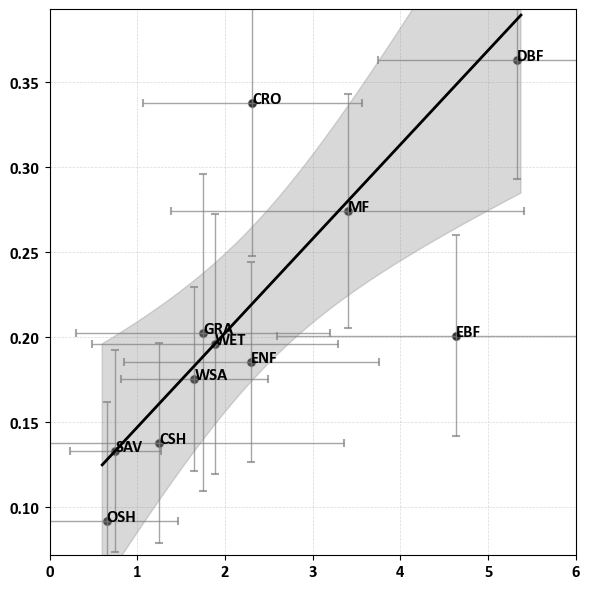

In [227]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming 'types', 'lai_std', 'nirv_std', 'lai', and 'nirv' are defined earlier in your code

# Count measurements for each type
num_measurements = site_annual_max_lue["type"].value_counts()
num_measurements = num_measurements.reindex(types, fill_value=0).values

# Calculate weights as the inverse of the variance and number of measurements
weights = num_measurements / (lai_std**2 + nirv_std**2)

# Perform weighted linear regression
A = np.vstack([lai, np.ones_like(lai)]).T
weighted_A = A * np.sqrt(weights[:, np.newaxis])
weighted_nirv = nirv * np.sqrt(weights)

# Solve weighted least squares
beta_linear, _, _, _ = np.linalg.lstsq(weighted_A, weighted_nirv, rcond=None)

# Calculate p-values for linear fit
n = len(lai)
y_pred_linear = beta_linear[0] * lai + beta_linear[1]
residuals_linear = nirv - y_pred_linear
sse_linear = np.sum(residuals_linear**2)
mse_linear = sse_linear / (n - 2)
se_linear = np.sqrt(mse_linear * np.diag(np.linalg.inv(np.dot(A.T, A))))
t_stats_linear = beta_linear / se_linear
p_values_linear = 2 * (1 - stats.t.cdf(np.abs(t_stats_linear), n - 2))

# Plotting
plt.figure(figsize=(6, 6))

# Extract standard errors for nirv and lai
nirv_se = site_annual_max_lue_grouped_std["nirv"]
lai_se = site_annual_max_lue_grouped_std["lai"]

(_, caps, _) = plt.errorbar(
    x=site_annual_max_lue_grouped_mean["lai"],
    y=site_annual_max_lue_grouped_mean["nirv"],
    xerr=[np.minimum(site_annual_max_lue_grouped_mean["lai"], lai_se), lai_se],
    yerr=nirv_se,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
for cap in caps:
    cap.set_markeredgewidth(1.5)

# Add black bullets
plt.scatter(
    site_annual_max_lue_grouped_mean["lai"],
    site_annual_max_lue_grouped_mean["nirv"],
    color="black",
    alpha=0.8,
    edgecolor="white",
    s=50,
)

# Generate fitted values
x_min = site_annual_max_lue_grouped_mean["lai"].min() - 0.05
x_max = site_annual_max_lue_grouped_mean["lai"].max() + 0.05
lai_fit = np.linspace(x_min, x_max, 100)
fit_line = beta_linear[0] * lai_fit + beta_linear[1]

# Plot linear regression line
plt.plot(lai_fit, fit_line, color="black", linewidth=2, label="Weighted Linear Fit")

# Calculate confidence intervals for linear fit
n = len(site_annual_max_lue_grouped_mean["lai"])
mean_lai = np.mean(site_annual_max_lue_grouped_mean["lai"])
SS_x = np.sum((site_annual_max_lue_grouped_mean["lai"] - mean_lai) ** 2)
SE_y_linear = np.sqrt(
    np.sum(
        (
            site_annual_max_lue_grouped_mean["nirv"]
            - (
                beta_linear[0] * site_annual_max_lue_grouped_mean["lai"]
                + beta_linear[1]
            )
        )
        ** 2
    )
    / (n - 2)
)
df_linear = n - 2
t_score_linear = stats.t.ppf((1 + 0.95) / 2, df_linear)

conf_interval_linear = (
    t_score_linear * SE_y_linear * np.sqrt(1 / n + (lai_fit - mean_lai) ** 2 / SS_x)
)
y_fit_upper_linear = fit_line + conf_interval_linear
y_fit_lower_linear = fit_line - conf_interval_linear

# Add the linear confidence interval as a shaded area
plt.fill_between(
    lai_fit, y_fit_lower_linear, y_fit_upper_linear, color="gray", alpha=0.3
)

# Get the current axes
ax = plt.gca()

# Add gridlines for better readability
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

plt.xticks(fontsize=12, weight="bold")
plt.yticks(fontsize=12, weight="bold")

plt.xlim(0, 6)
plt.ylim(
    site_annual_max_lue_grouped_mean["nirv"].min() - 0.02,
    site_annual_max_lue_grouped_mean["nirv"].max() + 0.03,
)

plt.tight_layout()

# Calculate R-squared for the fit
r_squared_linear = r2_score(
    site_annual_max_lue_grouped_mean["nirv"],
    beta_linear[0] * site_annual_max_lue_grouped_mean["lai"] + beta_linear[1],
)

# Overall p-value for linear model
F_linear = (r_squared_linear / 1) / ((1 - r_squared_linear) / (n - 2))
p_value_linear = 1 - stats.f.cdf(F_linear, 1, n - 2)

for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (
            site_annual_max_lue_grouped_mean["lai"][i],
            site_annual_max_lue_grouped_mean["nirv"][i],
        ),
        fontsize=12,
        weight="bold",
    )

# Print results
print(f"Linear fit: NIRV = {beta_linear[0]:.4f} * LAI + {beta_linear[1]:.4f}")
print(f"Linear R-squared: {r_squared_linear:.4f}")
print(
    f"Linear p-values: LAI: {p_values_linear[0]:.4f}, Intercept: {p_values_linear[1]:.4f}"
)
print(f"Linear overall p-value: {p_value_linear:.4f}")

plt.savefig("../outputs/figures/nirv_lai_regression.png", dpi=300, bbox_inches="tight")
plt.show()

In [215]:
site_annual_max_lue_grouped_mean

,fpar,nirv,nirvp,fesc,lue,lai,glass_lai
type,,,,,,,
CRO,0.710000,0.337544,120.418823,0.503605,0.069540,2.3125,3.26875
CSH,0.500000,0.138092,49.214404,0.358201,0.046941,1.2500,1.63750
DBF,0.901250,0.362982,98.551784,0.506816,0.053090,5.3250,5.60625
EBF,0.868125,0.201026,46.852877,0.320755,0.042413,4.6375,4.76875
ENF,0.720000,0.185522,43.387824,0.313459,0.049930,2.3000,2.86250
GRA,0.595000,0.202742,52.664821,0.396978,0.045247,1.7500,2.16250
MF,0.830000,0.274106,74.913595,0.420424,0.065108,3.4000,4.80000
OSH,0.327500,0.091854,33.926487,0.389519,0.028662,0.6500,0.70625
SAV,0.463750,0.133121,41.033376,0.347241,0.033797,0.7500,1.03125


In [ ]:
from sklearn.linear_model import LinearRegression

pd.plotting.scatter_matrix(
    site_annual_max_lue[["lue", "fesc", "fpar", "nirv", "nirvp", "lai"]],
    alpha=0.2,
    figsize=(10, 10),
    diagonal="kde",
)
# Create a linear regression model
model = LinearRegression()

# Fit the model using "fesc" as the independent variable and "lue" as the dependent variable
model.fit(site_annual_max_lue[["lue"]], site_annual_max_lue[["nirv"]])

# Calculate the R score
# r_score = model.score(site_annual_max_lue[["lue"]], site_annual_max_lue[["fesc"]])
# print("R score:", r_score)
r = np.corrcoef(site_annual_max_lue["lue"], site_annual_max_lue["nirv"])[0, 1]
print("R:", r)

r_squared = r**2
print("R^2:", r_squared)

In [ ]:
site_annual_max_lue = site_annual_max_lue[site_annual_max_lue["fesc"] <= 1]
site_annual_max_lue_se = site_annual_max_lue_se[
    site_annual_max_lue_se.index.isin(site_annual_max_lue.index)
]
site_annual_max_lue_grouped_mean = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai"]]
    .groupby("type")
    .median()
)
site_annual_max_lue_grouped_std = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai"]]
    .groupby("type")
    .std()
)
n = site_annual_max_lue.groupby("type").size()
site_annual_max_lue_grouped_se = site_annual_max_lue_grouped_std.div(np.sqrt(n), axis=0)

In [ ]:
# site_annual_max_lue_grouped_mean = site_annual_max_lue_grouped_mean.drop(
#     ["DBF_low", "SAV_low", "EBF_mid"], errors="ignore"
# )

In [ ]:
site_annual_max_lue_grouped_mean

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("LUE", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)
plt.savefig("../outputs/figures/between_pft_scatter.png", dpi=300, bbox_inches="tight")

# Display the DataFrame with results
# print(results_df)

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lai"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("LAI", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)
# Display the DataFrame with results
# print(results_df)

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
plt.figure(figsize=(4, 4))
# host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# Plot 'lai' vs 'lue'
plt.scatter(df_to_plot["lai"], df_to_plot["lue"])

# Add labels next to the points
for line in range(df_to_plot.shape[0]):
    plt.text(
        df_to_plot["lai"].iloc[line],
        df_to_plot["lue"].iloc[line],
        df_to_plot.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Add labels to the axes
plt.xlabel("lai")
plt.ylabel("lue")

plt.tight_layout()
plt.show()

In [ ]:
site_annual_max_lue_grouped_mean["ci_lai"] = (
    site_annual_max_lue_grouped_mean["ci"] * site_annual_max_lue_grouped_mean["lai"]
)

In [ ]:
site_annual_max_lue_grouped_mean

In [ ]:
import matplotlib.pyplot as plt

lue_values = site_annual_max_lue_grouped_mean["lue"].values
nirv_values = site_annual_max_lue_grouped_mean["nirv"].values
lai_values = site_annual_max_lue_grouped_mean["lai"].values

# Calculate the derivatives
dlue_dlai = np.gradient(lue_values, lai_values)
dnirv_dlai = np.gradient(nirv_values, lai_values)

# Add the derivatives back to the DataFrame
site_annual_max_lue_grouped_mean["dlue_dlai"] = dlue_dlai
site_annual_max_lue_grouped_mean["dnirv_dlai"] = dnirv_dlai

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot the 'dlue_dlai' derivative
site_annual_max_lue_grouped_mean.plot(x="lai", y="dlue_dlai", kind="scatter", ax=axs[0])

# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    axs[0].text(
        site_annual_max_lue_grouped_mean["lai"].iloc[line],
        site_annual_max_lue_grouped_mean["dlue_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Plot the 'dnirv_dlai' derivative
site_annual_max_lue_grouped_mean.plot(
    x="lai", y="dnirv_dlai", kind="scatter", ax=axs[1]
)
# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    axs[1].text(
        site_annual_max_lue_grouped_mean["lai"].iloc[line],
        site_annual_max_lue_grouped_mean["dnirv_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the R-squared value
# r2_linear = model.score(site_annual_max_lue_grouped_mean[['dlue_dlai']], site_annual_max_lue_grouped_mean[['dnirv_dlai']])

# Create a new figure
plt.figure(figsize=(6, 6))

# Plot the 'dnirv_dlai' derivative against the 'dlue_dlai' derivative
site_annual_max_lue_grouped_mean.plot(x="dlue_dlai", y="dnirv_dlai", kind="scatter")

# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    plt.text(
        site_annual_max_lue_grouped_mean["dlue_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean["dnirv_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Add the R-squared value to the plot
# plt.text(0.05, 0.95, f'R² = {r2_linear:.2f}', ha='left', va='top', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [ ]:
zi

In [ ]:
lue_values = site_annual_max_lue_grouped_mean["lue"].values
nirv_values = site_annual_max_lue_grouped_mean["nirv"].values
ci_lai_values = site_annual_max_lue_grouped_mean["ci_lai"].values

# Calculate the derivatives
dlue_dci_lai = np.gradient(lue_values, ci_lai_values)
dnirv_dci_lai = np.gradient(nirv_values, ci_lai_values)

In [ ]:
plt.plot(ci_lai_values, dlue_dci_lai, "*")

In [ ]:
plt.plot(ci_lai_values, dnirv_dci_lai, "*")

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "struct"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("structure", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)


# Display the DataFrame with results
# print(results_df)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplots
site_annual_max_lue.boxplot(column="lue", by="type", widths=0.6, ax=ax)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelsize=14, labelrotation=45)
plt.tick_params(axis="y", labelsize=14)
plt.ylim(0, 0.18)
ax.grid(color="gray", linestyle="-", alpha=0.3)
fig.suptitle("")

# for tick in ax.get_xticklabels():
#     tick.set_fontweight('bold')
# for tick in ax.get_yticklabels():
#     tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_lue_box.png")

In [ ]:
cite = pd.read_csv("../data/citations_for_site_data_Ameriflux.csv", skiprows=5)
cite.rename(columns={"site_id": "name"}, inplace=True)

# Initialize an empty DataFrame to store the results
data_cite = []

for name in names:
    site_name = name
    site_type = df[df["name"] == name]["type"].values[0]
    t1 = df[df["name"] == name].index[0]
    t2 = df[df["name"] == name].index[-1]
    date_range = str(t1.date()) + " - " + str(t2.date())
    site_cite = cite[cite["name"] == name]

    if len(site_cite) == 0:
        doi_url = "FLUXNET2015"
        data_cite.append(
            {
                "Name": site_name,
                "Type": site_type,
                "Date Range": date_range,
                "URL": doi_url,
            }
        )
        continue
    doi_url = site_cite["doi_url"].values[0]
    data_cite.append(
        {
            "Name": site_name,
            "Type": site_type,
            "Date Range": date_range,
            "URL": doi_url,
        }
    )
data_cite = pd.DataFrame(data_cite)
data_cite.to_csv("../outputs/data_cite.csv", index=False)

In [ ]:
results = []
for type in types:
    df_type = df[df["type"] == type]
    number_of_sites = len(df_type["name"].unique())
    number_of_obs = len(df_type)
    results.append(
        {
            "Type": type,
            "Number of Sites": number_of_sites,
            "Number of Observations": number_of_obs,
        }
    )
results = pd.DataFrame(results)
results.to_csv("../outputs/data_summary.csv", index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplots
site_annual_max_lue.boxplot(column="fesc", by="type", widths=0.6, ax=ax)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelsize=14, labelrotation=45)
plt.tick_params(axis="y", labelsize=14)
ax.grid(color="gray", linestyle="-", alpha=0.3)
ax.xaxis.label.set_weight("bold")
fig.suptitle("")

# for tick in ax.get_xticklabels():
#     tick.set_fontweight('bold')
# for tick in ax.get_yticklabels():
#     tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_fesc_box.png")

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Set a style and context for seaborn
sns.set(
    style="white", context="paper", font_scale=0.8
)  # Changed style to "white" to remove grids

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(10, 2.5))  # Adjusted figure size
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Variable", "Slope", "Intercept", "R_squared"])

for i, x in enumerate(variables):
    # Fit the model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])

    # Store slope, intercept, and R² in the DataFrame
    results_df.loc[i] = [x, model.coef_[0][0], model.intercept_[0], r2]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        # hue="type",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            df_to_plot[x].iloc[line] + 0.01,
            df_to_plot[y].iloc[line] + 0.001,
            df_to_plot.index[line],
            horizontalalignment="center",
            size="small",
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        f"R² = {r2:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )  # Reduced font size

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")  # Removing y-label
    if i == 0:
        host[i].set_ylabel(
            "LUE", fontsize=10, fontweight="bold"
        )  # Added y-label to the first subplot

plt.tight_layout(pad=0.01)  # Adjust subplot parameters to give specified padding
plt.savefig("../outputs/figures/between_pft_scatter.png", dpi=300, bbox_inches="tight")

# Display the DataFrame with results
print(results_df)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Load your data for site_annual_max_grouped_mean and site_annual_max_grouped_std
# Assuming these are already defined in your environment

df_to_plot = site_annual_max_lue_grouped_mean
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

for x in variables:
    # Create a single subplot with custom size
    fig, host = plt.subplots(1, 1, figsize=(3.5, 3.8))
    # Fit the model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        # hue="type",
        ax=host,
        color="black",
        legend=False,
        s=50,
    )
    plt.errorbar(
        df_to_plot[x],
        df_to_plot[y],
        xerr=site_annual_max_lue_grouped_se[x],
        yerr=site_annual_max_lue_grouped_se[y],
        fmt="none",
        color="black",
        alpha=0.25,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            df_to_plot[x].iloc[line] + 0.002,
            df_to_plot[y].iloc[line] + 0.0005,
            df_to_plot.index[line],
            horizontalalignment="center",
            size=12,
            color="black",
            # weight="semibold",
        )

    # Add R² to the plot
    host.text(
        0.1,
        0.9,
        f"R² = {r2:.2f}",
        transform=host.transAxes,
        fontsize=12,
        fontweight="bold",
    )

    # Set labels and title
    host.set_xlabel("")
    host.set_ylabel("")
    host.set_ylabel("")
    host.tick_params(axis="x", labelsize=12)
    host.tick_params(axis="y", labelsize=12)

    # Save the figure with x and y variables replaced in the filename
    plt.tight_layout(pad=0.01)
    plt.savefig(
        f"../outputs/figures/between_pft_{x}_{y}.png", dpi=300, bbox_inches="tight"
    )
    plt.clf()  # Clear the figure for the next iteration

# Close the figure
plt.close()

In [ ]:
site_annual_max_lue["type"].unique()

In [ ]:
types = site_annual_max_lue["type"].unique()

fig, axs = plt.subplots(3, 4, figsize=(10, 10))  # Reduced figure size to fit A4 paper
axs = axs.flatten()

for i, type in enumerate(types):
    print(type)
    x = "fesc"
    y = "lue"
    site_annual_max_type = site_annual_max_lue[site_annual_max_lue["type"] == type]
    site_annual_max_se_type = site_annual_max_lue_se[
        site_annual_max_lue_se["type"] == type
    ]
    df_to_plot = site_annual_max_type
    axs[i].scatter(
        df_to_plot[x], df_to_plot[y], color="black", marker="+", s=50
    )  # Added color, alpha, and edgecolor for better visualization
    axs[i].set_title(f"{type}", fontsize=12)  # Adjusted font size
    axs[i].set_xlabel(x, fontsize=12)  # Adjusted font size
    axs[i].set_ylabel("LUE$_{\mathrm{Max}}$", fontsize=12)

    axs[i].errorbar(
        df_to_plot[x],
        df_to_plot[y],
        xerr=site_annual_max_se_type[x],
        yerr=site_annual_max_se_type[y],
        fmt="none",
        color="black",
        alpha=0.3,
    )

    # Calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    axs[i].text(
        0.1, 0.9, f"R² = {r:.2f}", transform=axs[i].transAxes, fontsize=12
    )  # Add R² to the plot
    axs[i].tick_params(axis="both", labelsize=8)  # Adjusted font size

# Remove the extra subplots
for j in range(len(types), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
# plt.savefig(
#     "../outputs/figures/within_pft_fesc_lue.png", dpi=300, bbox_inches="tight"
# )  # Adjusted file name and dpi

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

variables = ["fesc"]  # Variables to loop over
y = "lue"
site_r2 = {var: [] for var in variables}  # Initialize a dictionary to store R² values
site_types = []  # Initialize a list to store the types

for name in names:
    tmp_df = df[df["name"] == name]
    site_types.append(tmp_df["type"].iloc[0])  # Append the type of the site
    for x in variables:
        model = LinearRegression().fit(tmp_df[[x]], tmp_df[[y]])
        r2 = model.score(tmp_df[[x]], tmp_df[[y]])
        site_r2[x].append(r2)  # Append R² to the corresponding list in the dictionary

# Convert the dictionary to a pandas DataFrame
r2_df = pd.DataFrame(site_r2, index=names)
r2_df["type"] = site_types  # Add the types as a new column

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

name = names[1]
tmp_df = df[df["name"] == name]
x = "lue"
y = "apar"
# Melt the DataFrame to have a long format
r2_df_melted = r2_df.melt(id_vars="type", var_name="variable", value_name="r2")

# Remove 'SNO' and 'CVM' types
r2_df_melted = r2_df_melted[~r2_df_melted["type"].isin(["SNO", "CVM"])]

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(
    x="type", y="r2", hue="variable", data=r2_df_melted, color="white"
)
# plt.title("R² for different variables by type")

# Change legend labels
new_labels = [f"{var} vs LUE" for var in r2_df.columns if var != "type"]
for t, l in zip(box_plot.legend_.texts, new_labels):
    t.set_text(l)
# Add horizontal line
plt.axhline(y=0.5, color="red", linestyle="--", c="gray")

# Remove legend title
box_plot.legend_.set_title(None)
box_plot.legend_.remove()
box_plot.set_xlabel("")
box_plot.set_ylabel(r"$R^2$", fontsize=14)
box_plot.tick_params(axis="x", labelsize=12)
box_plot.tick_params(axis="y", labelsize=12)
plt.savefig(
    "../outputs/figures/within_sites_r2_fesc_lue.png", dpi=300, bbox_inches="tight"
)